In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import glob
import matplotlib.pyplot as plt

from torch.utils.data import ConcatDataset, DataLoader

import vxs

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



In [2]:
PAD_TRACK_LEN = 4096*16
CUT_FRAME_WINDOW = 4096*16
PAD_SPECGRAM = PAD_TRACK_LEN // 512

vocal_sketch_dataset = vxs.SampleSet(glob.glob('../data/vocal-sketch/interactiveaudiolab-VocalSketchDataSet-6c9f381/vocal_imitations/included/*.wav'),
                                     pad_track=PAD_TRACK_LEN, pad_specgram=PAD_SPECGRAM, sgram_type='bark')
drum_machines_dataset = vxs.SampleSet(glob.glob('../data/200-drum-machines/drums/*/*.wav'),
                                      pad_track=PAD_TRACK_LEN, pad_specgram=PAD_SPECGRAM, sgram_type='bark')
avp_set_fixed = vxs.SampleSet(tracks=vxs.SegmentSet(vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset', subset='Fixed'),
                                                    frame_window=CUT_FRAME_WINDOW, return_class=False),
                              pad_track=PAD_TRACK_LEN, pad_specgram=PAD_SPECGRAM, sgram_type='bark')
common_set = ConcatDataset([vocal_sketch_dataset, drum_machines_dataset, avp_set_fixed])

In [3]:
len(common_set)

15652

In [4]:
len(drum_machines_dataset)

6749

In [5]:
len(vocal_sketch_dataset)

4429

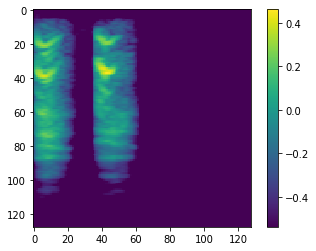

torch.Size([128, 128])


In [9]:
def sample_random(num, ln, seed):
    np.random.seed(seed)
    return np.random.randint(0, ln, size=num)

def imshow_random_samples(dataset, num, random_seed=42, cols=3):
    samples = sample_random(num, len(dataset), random_seed)
    rows = num // cols + (0 if num % cols == 0 else 1)
    fig, axes_t = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = [ax for tp in axes_t for ax in tp]
    
    for (sample_idx, ax) in zip(samples, axes):
        sample = dataset[sample_idx]
        ax.imshow(sample.cpu().squeeze(0).numpy())
        ax.set_title(sample_idx)
        
    plt.show()
    
def imshow_ae_output(model, dataset, num, random_seed=42):
    model.eval()
    model_device = next(model.parameters()).device
    samples = sample_random(num, len(dataset), random_seed)
    fig, axes = plt.subplots(num, 3, figsize=(12, 4*num))
    
    for (sample_idx, (ax1, ax2, ax3)) in zip(samples, axes):
        sample = dataset[sample_idx].to(model_device)
        sample_out, z = model(sample.unsqueeze(0))
        sample = sample.detach().squeeze().cpu().numpy()
        sample_out = sample_out.detach().squeeze().cpu().numpy()
        z = z.detach().squeeze().cpu().numpy().reshape(16, -1)
        mse = np.square(sample - sample_out).mean()
        dim = z.size
        
        ax1.imshow(sample)
        ax2.imshow(sample_out)
        ax3.imshow(z)
        ax1.set_title('Input')
        ax2.set_title(f'Output (MSE={mse})')
        ax3.set_title(f'Hidden rep (dim={dim})')
        
    plt.show()
    
melgram = common_set[44][0]
im = plt.imshow(melgram.cpu().squeeze(0).numpy())
plt.colorbar(im)
plt.show()
print(melgram.shape)

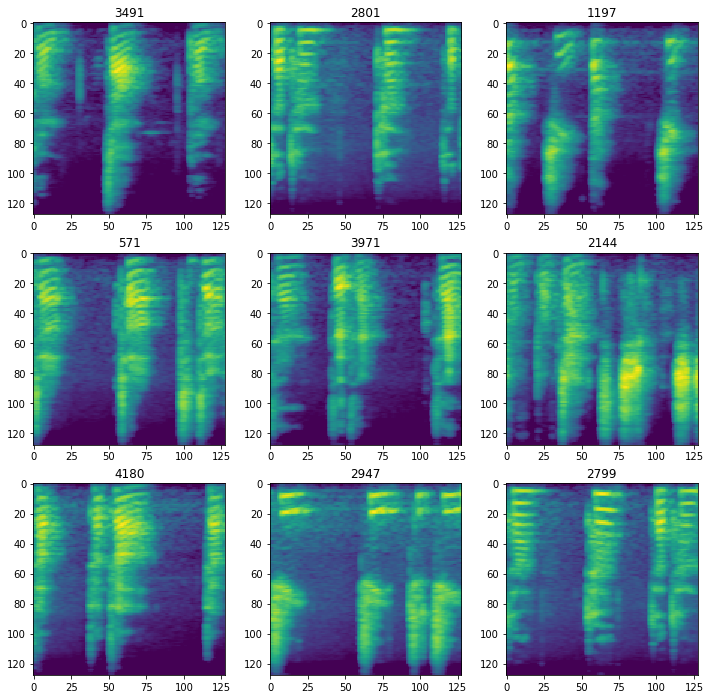

In [7]:
imshow_random_samples(avp_set_fixed, 9, random_seed=44, cols=3)

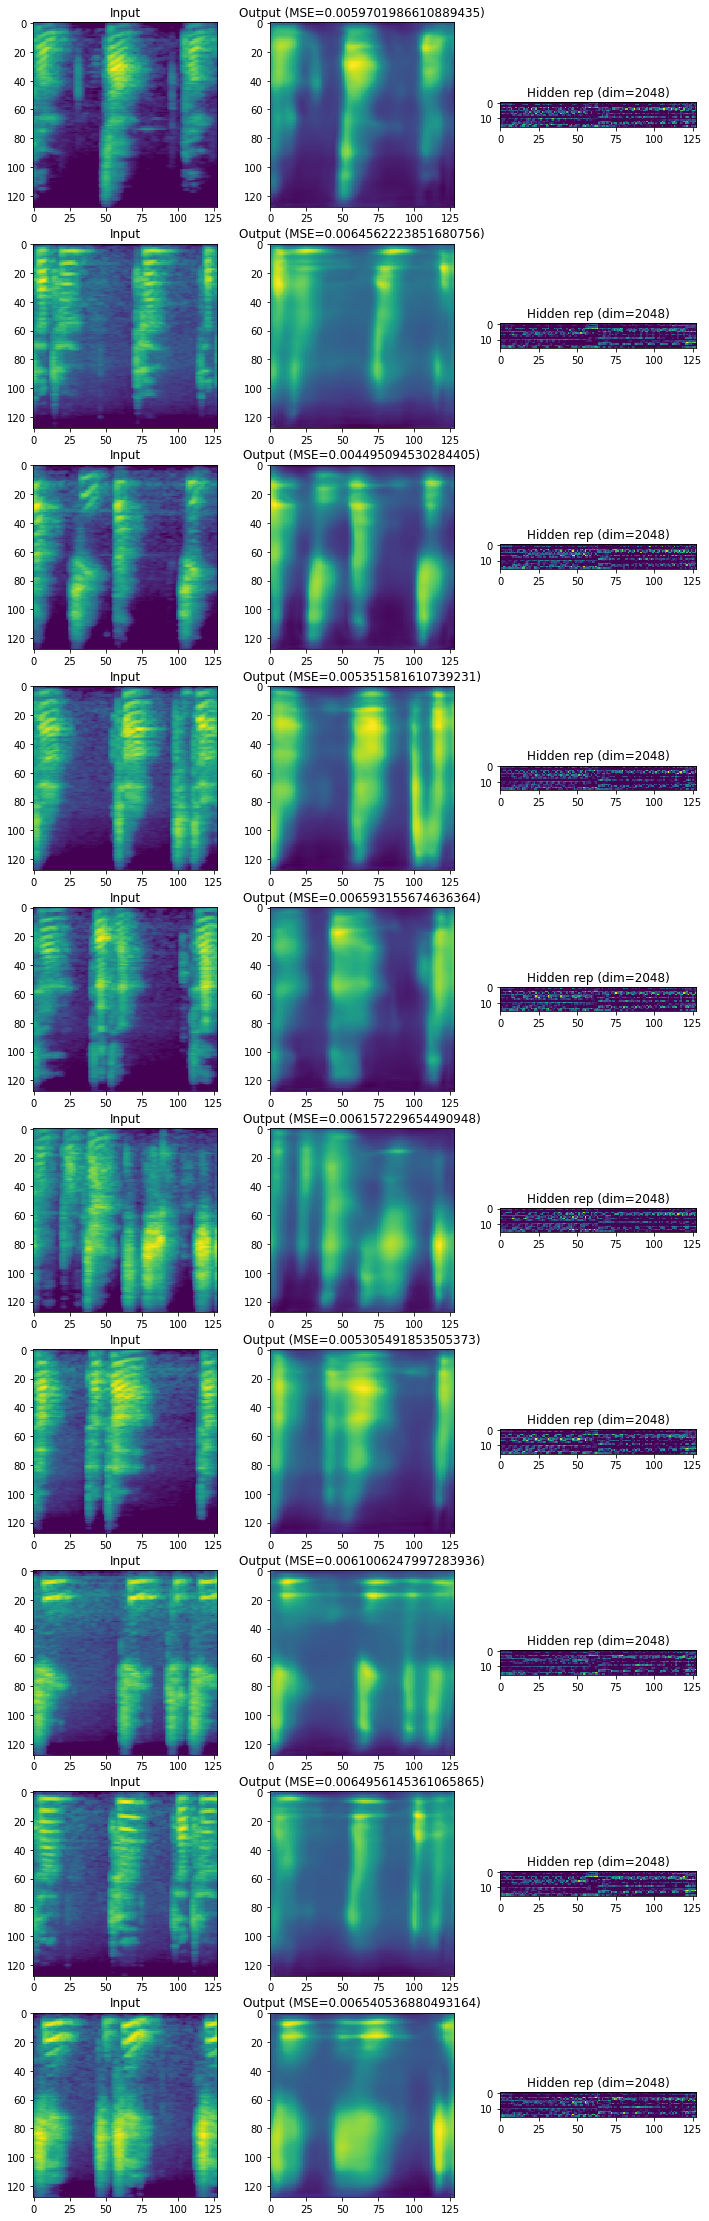

In [11]:
model = vxs.get_CAE_model('square-1', '../logs/cae-bark-finaldata_65536_square-1/checkpoints/best.pth')
imshow_ae_output(model, avp_set_fixed, 10, random_seed=44)

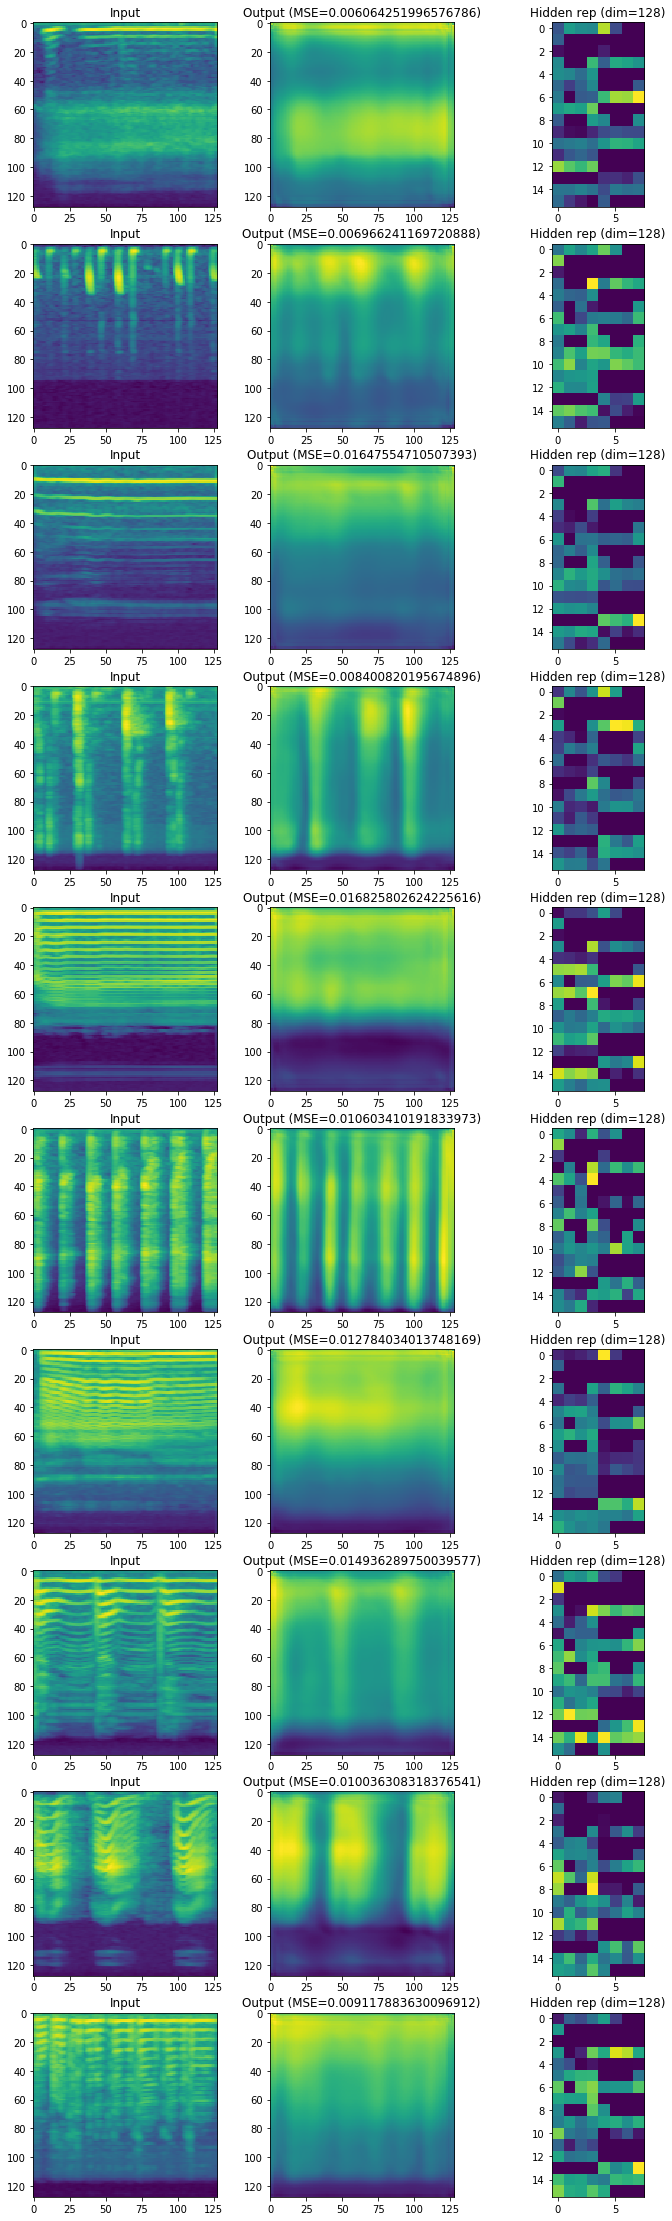

In [14]:
model_wide = vxs.get_CAE_model('wide-4', '../logs/cae-initial_65536_wide-4/checkpoints/best.pth')
imshow_ae_output(model_wide, vocal_sketch_dataset, 10, random_seed=44)

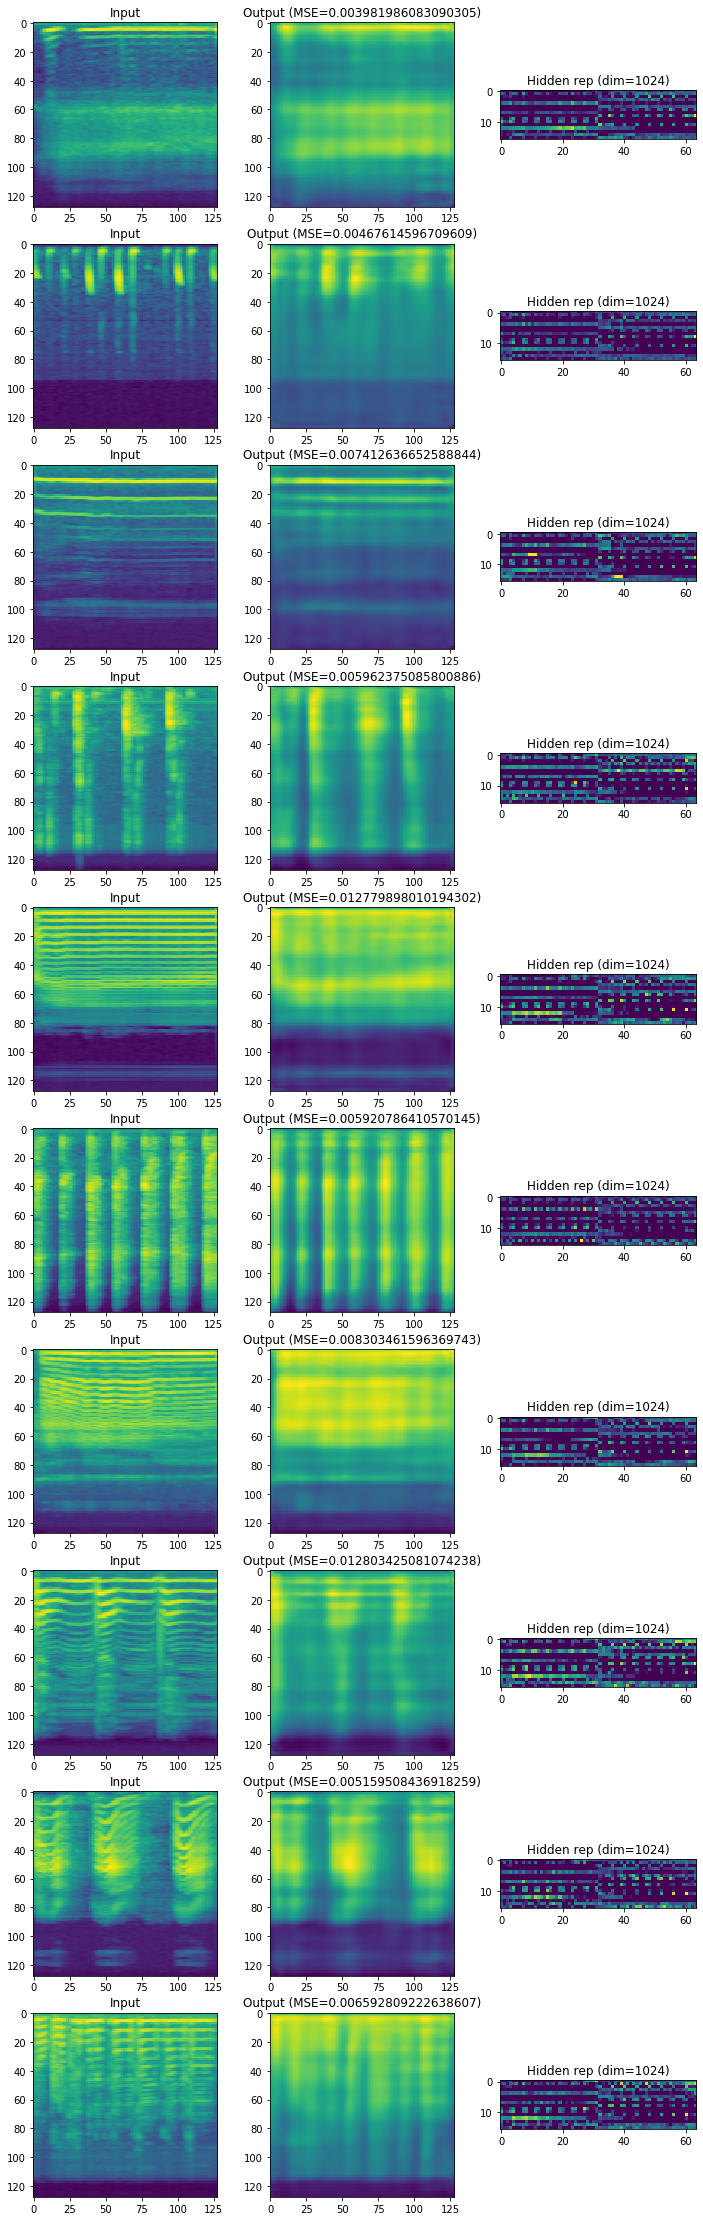

In [15]:
model_tall = vxs.get_CAE_model('tall-1', '../logs/cae-initial_65536_tall-1/checkpoints/best.pth')
imshow_ae_output(model_tall, vocal_sketch_dataset, 10, random_seed=44)